<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [1]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb


from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

In [5]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T144523Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00462219b0ebe818d563608321055ba2207078282c44e3b075e950032780082a118204ce14ec335c426ca18669f9166700011d560ca2bc1641e59ca5b4bd2882a9bf146ebb14118cea90e0209e56cfc40042b62cf457c19d5f56e4b3414045b02e4dd73a4ceda38d22d36574e5241ac191c75e55da23024c1cd6ec55bf123ac183a23e3f3046e6af008197b72d7ad1fb231fa437b1c1b7ba77409812894517922f998412f8cf8c7cdfa3475fd1f1f2bde73411ba6c5f743a0f43fb518031ebfcf06064cb3887fbfb427420f7f10b32c7fb25d0754cd811191ee8179d27898d9128f54e3087eb7e2ef6760b7314facc37e1cc5839ce75130b95bbb6e60a4a4243'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2529839 bytes downloaded
Downloaded and uncompressed: playground-series-s4e4
Data source import complete.


In [6]:
#comp = 'playground-series-s4e4'

In [31]:
!ls /kaggle/input/playground-series-s4e4

sample_submission.csv  test.csv  train.csv


In [38]:
# Next, install the Kaggle API client.
#!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"7590231111c5bbe2ad242827b0ef016c"}'}

In [39]:

 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
#!kaggle datasets list


mkdir: cannot create directory ‘/root/.kaggle’: File exists


Set random seed for reproducibility.

In [ ]:
#set_seed(42)

In [8]:
path = Path('/kaggle/input/playground-series-s4e4/')
path

Path('/kaggle/input/playground-series-s4e4')

Index_col

With or without.

I remove the index_col because it changes the shape of our original dataset.
 Later on we shall be able to investigate the effect of this action.

In [9]:
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')


In [10]:
train_df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [12]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')

In [13]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [14]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [15]:
to.xs.iloc[:2]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
73337,2,0.361065,0.388894,-0.013853,0.182349,-0.125451,0.117894,0.184291
24007,3,1.461335,1.256475,2.224061,2.396492,2.817927,2.310155,1.761093


In [16]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [17]:
model = xgb.XGBRegressor(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)

In [18]:
xgb_model = model.fit(X_train, y_train)

In [23]:
xgb_preds = tensor(model.predict(X_test))

In [25]:
rmse(xgb_preds, tensor(y_test))

TensorBase(1.8545)

Kaggle submission code from


https://www.kaggle.com/code/nguyncaoduy/fastai-tabular-regression-model-nn-xgb



In [36]:
dls = to.dataloaders(bs=64)

In [28]:
test_dl = dls.test_dl(test_df)

In [29]:
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds

In [32]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds # nn_preds
submit.head()

,id,Rings
0,90615,9.950949
1,90616,9.836530
2,90617,10.073667
3,90618,10.383504
4,90619,7.538304


In [33]:
submit.to_csv('submission.csv', index=False)

In [34]:
!ls

sample_data  submission.csv


In [35]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,9.950949
1,90616,9.836530
2,90617,10.073667
3,90618,10.383504
4,90619,7.538304


In [40]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost initial subm trial 1"

100% 962k/962k [00:00<00:00, 2.34MB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
model = xgb.XGBClassifier(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)
xgb_model = model.fit(X_train, y_train)

In [ ]:



# Example: Fit the model on a subset of data
xgb_model = model.fit(X_train.iloc[:100], y_train.iloc[:100])


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
xgb_model = model.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27], got [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 29]

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
dls.show_batch()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.530,0.420,0.175,0.9740,0.3675,0.2355,0.3100,12.0
1,I,0.290,0.210,0.070,0.1075,0.0410,0.0265,0.0450,6.0
2,F,0.590,0.455,0.145,0.9775,0.4680,0.1775,0.2660,9.0
3,I,0.300,0.230,0.090,0.1345,0.0545,0.0265,0.0435,6.0
4,F,0.675,0.510,0.170,1.2900,0.6045,0.3365,0.3600,11.0
5,F,0.565,0.450,0.160,1.1605,0.6075,0.2695,0.2485,9.0
6,F,0.410,0.335,0.125,0.4035,0.1750,0.0930,0.1290,8.0
7,M,0.565,0.455,0.155,0.9595,0.4565,0.2395,0.2300,9.0
8,M,0.600,0.470,0.165,1.0380,0.4975,0.2205,0.2915,10.0
9,F,0.525,0.430,0.140,0.7365,0.3045,0.1555,0.2175,10.0


In [ ]:
learn = tabular_learner(dls, metrics=rmse)

SuggestedLRs(slide=6.30957365501672e-05, valley=0.02754228748381138)

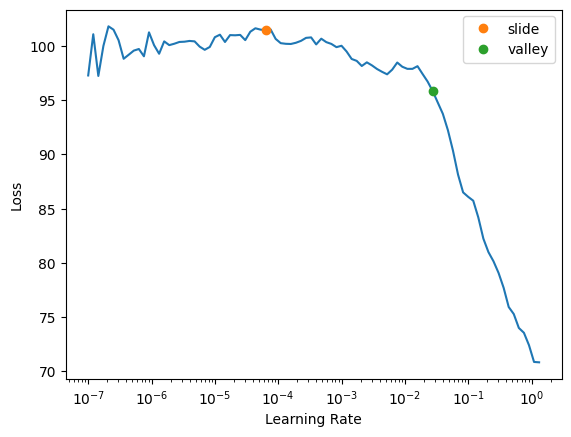

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit_one_cycle(3,slice(6.509573450380412e-07, 0.009120108559727669))

epoch,train_loss,valid_loss,_rmse,time
0,3.997837,4.085330,2.021220,00:12
1,3.971028,3.686301,1.919975,00:11
2,3.630424,3.492530,1.868831,00:13


In [ ]:
learn.show_results()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Rings_pred
0,1.0,0.739773,0.744402,1.037867,0.689753,0.675277,1.016799,0.526531,17.0,10.128865
1,2.0,-1.754108,-1.805133,-1.463092,-1.445008,-1.465443,-1.447723,-1.410766,8.0,6.260065
2,1.0,0.063466,-0.122440,-0.015169,-0.285452,-0.181499,-0.141229,-0.355802,12.0,8.830783
3,2.0,-0.993263,-0.989282,-0.936575,-0.994494,-0.994338,-1.066662,-1.000289,9.0,7.511511
4,3.0,0.486157,0.489448,0.379720,0.048343,-0.301106,0.116111,0.085365,10.0,11.706523
5,2.0,-0.739648,-0.632347,-0.804945,-0.898501,-0.891818,-0.952839,-0.854512,9.0,7.842739
6,1.0,0.359350,0.132514,-0.015169,0.153063,0.431181,-0.027406,-0.010541,9.0,8.902841
7,3.0,1.204733,1.050346,1.169496,1.805676,1.351422,1.259292,1.738780,11.0,14.093764
8,2.0,-1.246878,-1.295226,-0.936575,-1.215933,-1.199379,-1.126048,-1.180592,7.0,7.153389


In [ ]:
#row, clas, probs = learn.predict(df.iloc[0])
#row.show()

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
nn_preds = learn.get_preds(dl=dl)
nn_preds

(tensor([[ 9.3872],
         [ 9.6390],
         [10.2532],
         ...,
         [12.2946],
         [13.0651],
         [ 8.5944]]),
 None)

In [ ]:
nn_preds_x = learn.get_preds()[0]
nn_preds_x

tensor([[ 7.6516],
        [12.7676],
        [ 9.3306],
        ...,
        [12.4673],
        [15.7989],
        [ 9.0680]])

In [ ]:
nn_argmax = nn_preds_x.argmax(dim=1)
nn_argmax

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
!ls

kaggle.json  models  sample_data  sub-tree.csv


In [ ]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb


from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')


# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T132418Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2614deaa47c6cd905e4cdd6acd10fdf496604bbcae2b3fda248c90858a6f72c27e9c3be1ff3141903a83befe7fea039c459b9702f244616103f40546a6bab945b93e2f3f5c42517c88af809b449064671f22af0de774517811314fda01bf2c86f5a65098d31bd122c9b736d8af59944704e20719c70045136b7ee6fcd8622366df3263afeb70b6a84d8ffc2f4ad28b1362a75010e6e4b0d3d435a24fd794a0527bf8453598d8d9c988e769cec5d5c82f60ce82b0c7c784dc58788d00f248728a875a19c6755b5e08da6ca2ea38beb3003deee1dbacac986be3673f3221911468f9d844e43ab3e4d502066ff80686dd882256bff56bf83571eaa6ed2874564585'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

path = Path('/kaggle/input/playground-series-s4e4/')
#train_df = pd.read_csv(path/'train.csv',index_col='id')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
cont_names,cat_names = cont_cat_split(train_df, max_card=20 , dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
model = xgb.XGBClassifier(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)
xgb_model = model.fit(X_train, y_train)


In [ ]:
target_preds = nn_preds[0]

In [ ]:
test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['id','Rings'], index=False)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Rings
0,90615,9.387184
1,90616,9.638966
2,90617,10.253196
3,90618,10.038727
4,90619,7.671815


In [ ]:
!ls

kaggle.json  models  sample_data  submission.csv  sub-tree.csv


In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission.csv', 'initial rn26d 128px', comp)

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 3 with id column + no random seed "

100% 963k/963k [00:00<00:00, 2.38MB/s]
Successfully submitted to Regression with an Abalone Dataset

Neural Network Ensemble

SuggestedLRs(slide=0.0063095735386013985, valley=0.005248074419796467)

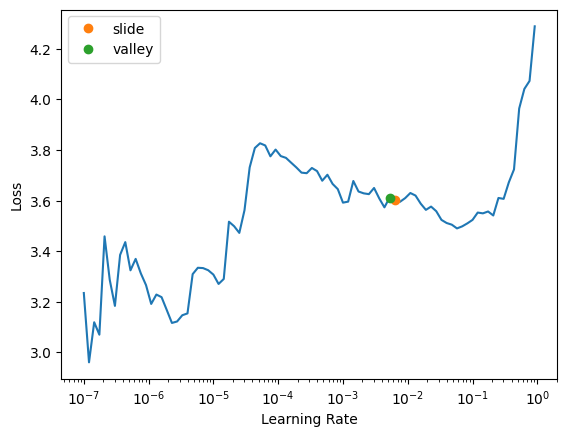

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=rmse)
    with learn.no_bar(),learn.no_logging(): learn.fit(2, 0.14)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(3)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
!ls

kaggle.json  models  sample_data


In [ ]:
submission = pd.DataFrame({
     # Assuming 'Id' is the identifier column
    'target': ens_preds
})

# Save your submission to a CSV file
submission.to_csv('submission.csv', index=False)

ValueError: If using all scalar values, you must pass an index

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub{suff}.csv', index=False)

subm(ens_preds, 'mission')

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network ensemble Sub 3 with id column + no random seed "

100% 965k/965k [00:00<00:00, 2.29MB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
#sub_df = pd.DataFrame(ens_preds, columns='Rings')
#sub_df['id'] = test_df['id']

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)

In [ ]:
#targets ='Rings'
#test_df[targets] = ens_preds
#sub_df['id'] = test_df['id']

#test_df.to_csv('submission.csv', columns=['Rings'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

,Rings
0,9.475194
1,9.920687
2,10.470133
3,10.523545
4,7.595455


In [ ]:
avgs = ens_ores


In [ ]:
ens_preds.shape

torch.Size([60411, 1])

In [ ]:
nn_preds_x.shape

torch.Size([18123, 1])

In [ ]:
ens_target_preds = ens_preds

In [ ]:
!ls

kaggle.json  models  sample_data


In [ ]:
targets = 'Rings'

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(ens_preds, 'tree')

In [ ]:
!ls

kaggle.json  models  sample_data  sub-tree.csv


In [ ]:
sub_tree = pd.read_csv('sub-tree.csv')
sub_tree

,Rings
0,9.475194
1,9.920687
2,10.470133
3,10.523545
4,7.595455
...,...
60406,6.357795
60407,9.535987
60408,11.601138
60409,13.247025


In [ ]:
ens_predsdf = pd.DataFrame(ens_preds,columns = ['Rings'])
ens_predsdf.insert(0,'id',test_df)
ens_predsdfid = ens_predsdf.set_index('id')

ValueError: Expected a 1D array, got an array with shape (60411, 9)

In [ ]:
#target_preds = ens_preds[0]
target_preds = ens_preds[0]
test_df['Rings'] = target_preds[0]

test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

ValueError: Length of values (1) does not match length of index (60411)

In [ ]:
submission['Rings'].value_counts()

12.240919    2
9.640627     2
9.273890     2
8.319525     2
9.454882     2
            ..
11.223063    1
7.700616     1
11.274849    1
16.073120    1
8.681573     1
Name: Rings, Length: 60158, dtype: int64

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Ensemble Sub 1"

100% 964k/964k [00:03<00:00, 272kB/s] 
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
ens_dl = learns.dls.test_dl(test_df)
nn_ens_preds = learns.get_preds(dl=ens_dl)

AttributeError: 'list' object has no attribute 'dls'

In [ ]:
#target_preds = ens_preds[0]
target_preds = ens_preds[0]
test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

ValueError: Length of values (1) does not match length of index (60411)

Prep data for random forest and XGBoost.

In [ ]:
to.xs[:3]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
81142,2,-0.060893,0.033288,-0.276259,-0.295537,-0.202349,-0.237821,-0.006724
55321,2,-1.627359,-1.549445,-1.457439,-1.398579,-1.391622,-1.298508,-1.517854
84907,3,-0.018556,-0.119880,-0.407502,-0.511991,-0.711339,-0.406341,-0.452757


In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

Random Forests

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

#roc_auc_score(y_test, rf.predict(X_test))

In [ ]:
rf_preds = rf.predict(X_test)

In [ ]:
!ls

kaggle.json  models  sample_data


In [ ]:
#target_preds = ens_preds[0]
#rf_target_preds = rf_preds[0]
rf_target_preds = rf_preds
test_df['Rings'] = rf_target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head(13)

ValueError: Length of values (18123) does not match length of index (60411)

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Random Forest Sub"

100% 522k/522k [00:00<00:00, 2.20MB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:

#roc_auc_score(y_test, rf.predict(X_test))

XGBoost

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
model = xgb.XGBClassifier(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)

In [ ]:
xgb_model = model.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27], got [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 29]

In [ ]:
xgb_preds = xgb_model.predict_proba(X_test)

NameError: name 'xgb_model' is not defined

In [ ]:
xgb_preds

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub"

In [ ]:
#roc_auc_score(y_test, xgb_preds)

General Ensemble

In [ ]:
avgs = (ens_preds + rf_preds) / 2
avgs

tensor([[ 9.2390,  8.7390,  7.2390,  ...,  9.2390, 11.2390,  9.2390],
        [ 9.3379,  8.8379,  7.3379,  ...,  9.3379, 11.3379,  9.3379],
        [ 9.5287,  9.0287,  7.5287,  ...,  9.5287, 11.5287,  9.5287],
        ...,
        [10.6971, 10.1971,  8.6971,  ..., 10.6971, 12.6971, 10.6971],
        [10.8055, 10.3055,  8.8055,  ..., 10.8055, 12.8055, 10.8055],
        [ 8.9384,  8.4384,  6.9384,  ...,  8.9384, 10.9384,  8.9384]])

In [ ]:
!ls

kaggle.json  models  sample_data


In [ ]:
#target_preds = ens_preds[0]
avgs_target_preds = avgs[0]
test_df['Rings'] = avgs_target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head(13)

ValueError: Length of values (18123) does not match length of index (60411)

In [ ]:
avgs = (nn_preds + xgb_preds + forest_preds) / 3
avgs

In [ ]:
#roc_auc_score(y_test, avgs)

Take argmax to return preds

In [ ]:
argmax = avgs.argmax(dim=1)
argmax

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub"

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Message"